In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tensorflow.keras.datasets import mnist
from IPython.display import display, Markdown, HTML, Latex

<div style="background-color:#2b2b2b; padding: 20px; border-radius: 8px; color: #d3d3d3; font-family: Arial, sans-serif;">
    <h2 style="color: #80cbc4; text-align: center;">Setup</h2>
    <h3 style="color: #ffab91; text-align: center;">Layers</h3>
    <ul style="line-height: 1.6; font-size: 1.05em;">
        <li><strong>1st layer (Input layer)</strong>: 784 neurons / input neurons</li>
        <li><strong>2nd layer (1st Hidden layer)</strong>: 16 neurons</li>
        <li><strong>3rd layer (2nd Hidden layer)</strong>: 16 neurons</li>
        <li><strong>4th layer (Output layer)</strong>: 10 neurons (0-9 digit classification)</li>
    </ul>
    <p style="font-size: 1.1em; text-align: center; color: #b0bec5;">
        <strong>Total parameters:</strong> 16 * 784 + 16 * 16 + 16 * 10 + (16 * 2 + 10) = 13,002
    </p>
</div>

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()


# Preprocessing the dataset
X_train = X_train / 255.0
X_test = X_test / 255.0

print('x_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('x_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (60000, 784)
y_train.shape: (60000,)
x_test.shape: (10000, 784)
y_test.shape: (10000,)


In [30]:
# TODO: Improve this to classes like, Layer, Neuron, etc.
params_required = ['accuracy', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4']


class Neuron:
  def __init__(self, nin):
    self.w = np.random.uniform(1, -1, nin)
    self.b = np.random.uniform(1, -1)
  def __repr__(self):
    return rf"Neuron(w={self.w.shape}, b={self.b:.4f})"

class Layer:
  def __init__(self, nn, nin):
    self.neurons = [Neuron(nin) for _ in range(nn)]

def display_image(X, y, idx, ax):
  image = X[idx]
  true_number = y[idx]
  ax.imshow(image, cmap='gray', interpolation='nearest')
  ax.axis('off') 
  if isinstance(ax, plt.Axes):
    ax.set_title(f"True Number: {true_number}", fontsize=12)

def display_number_as_img(X, y, num):
  indices = [i for i in range(len(X)) if num == y[i]]
  samples = np.random.choice(indices, 10, replace=False)
  fig, axes = plt.subplots(2, 5, figsize=(12, 5))
  fig.tight_layout(pad=3)
  for i in range(10):
      ax = axes[i // 5, i % 5]
      display_image(X, y, samples[i], ax)

  plt.show()


def init_params():
  w2 = np.random.uniform(-0.1, 0.1, (100, 784))
  b2 = np.zeros(100)
  w3 = np.random.uniform(-0.1, 0.1, (100, 100)) 
  b3 = np.zeros(100)
  w4 = np.random.uniform(-0.1, 0.1, (10, 100))
  b4 = np.zeros(10)
  return w2, b2, w3, b3, w4, b4

def softmax(z):
  z = z - np.max(z) # shifts everything left, so maximum value becomes zero
  z = np.exp(z)
  a = z / np.sum(z)
  return a

def dsoftmax(z):
    s = softmax(z).reshape(-1, 1) 
    return np.diagflat(s) - np.dot(s, s.T)

def dReLu(z):
  return z > 0

def ReLu(z): 
  return np.maximum(0, z)

def one_hot_encode(y, size):
  row_size, _ = size
  one_hot = np.zeros(size)
  one_hot[np.arange(0, row_size), y] = 1 
  return one_hot

def cross_entropy_loss(y, a4):
    return -np.sum(y * np.log(a4 + 1e-8))  

def feed_forward(X, w2, b2, w3, b3, w4, b4):
  X_flat = X.flatten()

  z2 = w2.dot(X_flat) + b2
  a2 = ReLu(z2)
  
  z3 = w3.dot(a2) + b3
  a3 = ReLu(z3)
  
  z4 = w4.dot(a3) + b4
  a4 = softmax(z4)

  return a4, z4, a3, z3, a2, z2, X_flat

k = 10
def backprop(y, a4, z4, a3, z3, a2, z2, w4, w3, w2, X_flat):
  # output layer
  delta4 = (a4 - y)

  grad_w4 = np.outer(delta4, a3)
  grad_b4 = delta4

                   
  # 2nd hidden layer
  delta3 = np.dot(delta4, w4) * dReLu(z3)
  grad_w3 = np.outer(delta3, a2)
  grad_b3 = delta3


  # 1st hidden layer
  delta2 = np.dot(delta3, w3) * dReLu(z2)
  grad_w2 = np.outer(delta2, X_flat)
  grad_b2 = delta2
  return grad_w2, grad_b2, grad_w3, grad_b3, grad_w4, grad_b4

def save_weights(**params):

  if not set(params_required).issubset(params.keys()):
    missing_params = set(params_required).difference(params.keys())
    raise ValueError(f"Missing parameters: {missing_params}")
    
  accuracy = params.get('accuracy', -1)
  
  best_accuracy = 0
  if os.path.exists('weights.npz'):
    data = np.load('weights.npz')
    best_accuracy = data.get('accuracy', 0)

  if accuracy <= best_accuracy:
    print("Weights not saved, accuracy is not better than previous")
    return
  
  np.savez("weights.npz", **params)
  print("Weights saved successfully previous accuracy was", best_accuracy, "new accuracy is", accuracy)
  print(f"Improved by {accuracy - best_accuracy:.2f}")


In [31]:

w2, b2, w3, b3, w4, b4 = init_params()
y_train_hot = one_hot_encode(y_train, (60000, y_train.max() + 1))
lr = 0.01
epochs = 10

max_patience = 15
patience_counter = 0
best_total_loss = np.inf
best_parameters = None

for epoch in range(epochs):
  total_loss = 0
  i = 0
  for x, y in zip(X_train, y_train_hot): 
    #feed forward
    a4, z4, a3, z3, a2, z2, X_flat = feed_forward(x, w2, b2, w3, b3, w4, b4) 
    loss = 1/2 * np.sum((y - a4)**2)

    total_loss += loss

    #backprop
    grad_w2, grad_b2, grad_w3, grad_b3, grad_w4, grad_b4 = backprop(
            y, a4, z4, a3, z3, a2, z2, w4, w3, w2, X_flat)

    #update weights
    w2 -= lr * grad_w2
    b2 -= lr * grad_b2
    w3 -= lr * grad_w3
    b3 -= lr * grad_b3
    w4 -= lr * grad_w4
    b4 -= lr * grad_b4

  if total_loss < best_total_loss:
    best_total_loss, patience_counter = total_loss, 0
    best_parameters = (w2, b2, w3, b3, w4, b4)
  elif (patience_counter := patience_counter + 1) == max_patience:
    break
  
  print(f"Epoch {epoch + 1}, Loss: {total_loss}")
  
correct_predictions = 0
total_predictions = len(X_test)

for x, y_true in zip(X_test, y_test):
    a4, _, _, _, _, _, _ = feed_forward(x, *best_parameters)
    t = np.argmax(a4)
    if t == y_true:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions * 100
print(f"Test Accuracy: {accuracy:.2f}%")

params = dict(zip([*params_required], (accuracy, *best_parameters)))
save_weights(**params)

KeyboardInterrupt: 

Number predicted is 1


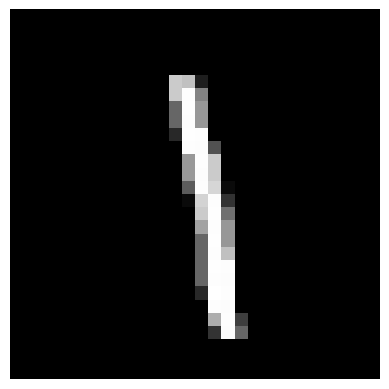

In [ ]:
#load weights
params = np.load("weights.npz")
acc, w2, b2, w3, b3, w4, b4 = [params[key] for key in params.keys()]
idx = 31
a4, _, _, _, _, _, _= feed_forward(X_test[idx], w2, b2, w3, b3, w4, b4)
predicted_number = np.argmax(a4)
print("Number predicted is", predicted_number)
display_image(X_test, y_test, idx, plt)

In [ ]:
import pygame
import numpy as np
from scipy.ndimage import zoom, gaussian_filter

def center_and_scale_grid(grid):
    if not np.any(grid):
        return grid
    
    rows = np.any(grid, axis=1)
    cols = np.any(grid, axis=0)
    
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    
    cropped_grid = grid[y_min:y_max+1, x_min:x_max+1]
    
    max_dim = max(cropped_grid.shape)
    scaling_factor = 20.0 / max_dim
    resized_grid = zoom(cropped_grid, scaling_factor)
    
    # Calculate padding to center the digit in a 28x28 grid
    h_padding = (28 - resized_grid.shape[0]) // 2
    v_padding = (28 - resized_grid.shape[1]) // 2
    
    # Create a new 28x28 grid and place the resized digit
    new_grid = np.zeros((28, 28))
    new_grid[h_padding:h_padding+resized_grid.shape[0], v_padding:v_padding+resized_grid.shape[1]] = resized_grid
    
    return new_grid

# Initialize Pygame
pygame.init()

scale = 15
width, height = 28 * scale, 28 * scale
screen = pygame.display.set_mode((width, height))
pygame.display.set_caption("Draw a Digit (Press Enter to Predict, 'C' to Clear)")

grid = np.zeros((28, 28))

brush_size = 2 

font_xl = pygame.font.Font(None, 36)
font_sm = pygame.font.Font(None, 25)

def draw_grayscale(x, y):
    if 0 <= x < 28 and 0 <= y < 28:
        grid[y, x] = min(1.0, grid[y, x] + 0.3)

def probability_to_rgb(prob):
    return (255 * (1 - prob), 0, 255 * prob)

running = True
predict = False
prediction_text = ""
predicted_probabilities = None

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_RETURN:
                predict = True 
            elif event.key == pygame.K_c:
                grid = np.zeros((28, 28))
                prediction_text = ""
                predicted_probabilities = None
        
        elif pygame.mouse.get_pressed()[0]:  
            x, y = pygame.mouse.get_pos()
            grid_x, grid_y = x // scale, y // scale 
            draw_grayscale(grid_x, grid_y)
    
    screen.fill((0, 0, 0)) 
    for y in range(28):
        for x in range(28):
            color = int(grid[y, x] * 255)
            pygame.draw.rect(screen, (color, color, color), (x * scale, y * scale, scale, scale))
    if prediction_text:
        text_surface = font_xl.render(prediction_text, True, (255, 255, 255))
        screen.blit(text_surface, (10, 10))
    
    if predicted_probabilities is not None:
        for i, prob in enumerate(predicted_probabilities):
            color = probability_to_rgb(prob)
            t = font_sm.render(f"{i}: {prob:.2f}", True, (255, 255, 255), color)
            screen.blit(t, (10, 11 + (i + 1) * 36))
    
    pygame.display.flip()

    if predict:
        centered_grid = center_and_scale_grid(grid)
        normalized_grid = centered_grid / np.max(centered_grid) if np.max(centered_grid) > 0 else centered_grid
        blurred_grid = gaussian_filter(normalized_grid, sigma=0.5)
        input_vector = blurred_grid.flatten()
        
        a4, _, _, _, _, _, _ = feed_forward(input_vector, w2, b2, w3, b3, w4, b4)
        
        predicted_probabilities = a4
        predicted_number = np.argmax(predicted_probabilities)
        confidence = predicted_probabilities[predicted_number] * 100  
        
        prediction_text = f"Prediction: {predicted_number} ({confidence:.2f}%)"
        print("Predicted probabilities:", predicted_probabilities)
        print(f"Number predicted is {predicted_number} with probability {confidence:.2f}%")
        
        predict = False  # Reset the flag

pygame.quit()

Predicted probabilities: [1.25827856e-04 2.99583427e-03 6.42579533e-03 9.75253657e-01
 3.73823878e-04 4.00144931e-03 2.43736820e-04 8.03902193e-04
 8.47369657e-03 1.30227687e-03]
Number predicted is 3 with probability 97.53%
Predicted probabilities: [3.90109372e-06 9.57492188e-01 9.31030471e-03 7.68631669e-03
 4.56102158e-04 2.18225018e-04 3.29571151e-04 8.32895019e-03
 1.58688834e-02 3.05557174e-04]
Number predicted is 1 with probability 95.75%
Predicted probabilities: [6.92551329e-06 9.76394531e-01 3.78582651e-03 3.27875035e-03
 8.52518040e-04 4.16304188e-04 5.67958378e-04 6.03183743e-03
 8.27121565e-03 3.94132583e-04]
Number predicted is 1 with probability 97.64%
Predicted probabilities: [2.33787249e-05 9.60613323e-01 1.35047897e-02 1.80576464e-03
 1.34771808e-03 7.41810980e-04 1.49330062e-03 7.69395900e-03
 1.25318982e-02 2.44056905e-04]
Number predicted is 1 with probability 96.06%
Predicted probabilities: [0.00411586 0.58269653 0.05084775 0.05281928 0.02707142 0.06476728
 0.05389